## Visualizing and understanding the data available.

In [1]:
# Install the necessary packages
!pip install torch torchvision albumentations tqdm opencv-python

# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import cv2

# Configure matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
%matplotlib inline


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


## Loading the dataset

In [9]:
train_data = pd.read_csv('/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train.csv')

In [21]:
train_data.head()

id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

In [10]:
train_images = glob('/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')

In [23]:
len(train_images)

38496

In [11]:
train_images[0]

'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png'

## Plotting a few images to visualize data randomly

**Each case has 144 scans, with a few being segmentation masks.
It is to be noted that not all cases have masks**

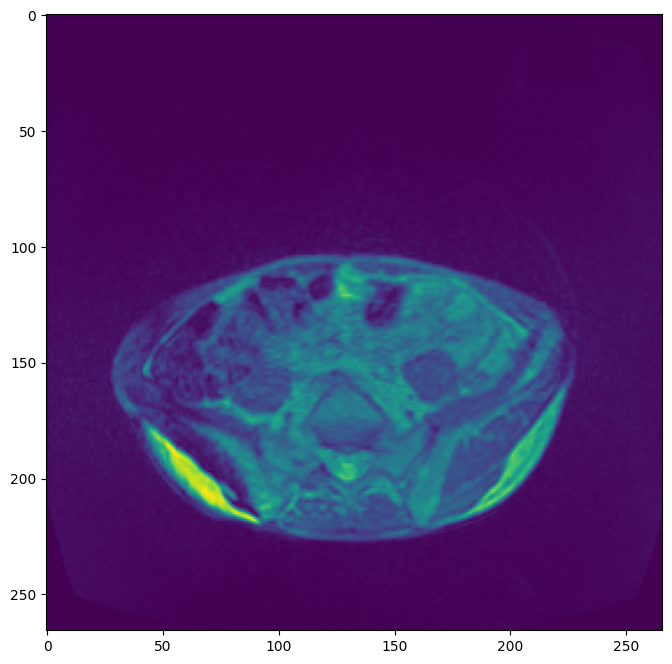

In [12]:
image = cv2.imread(train_images[0], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

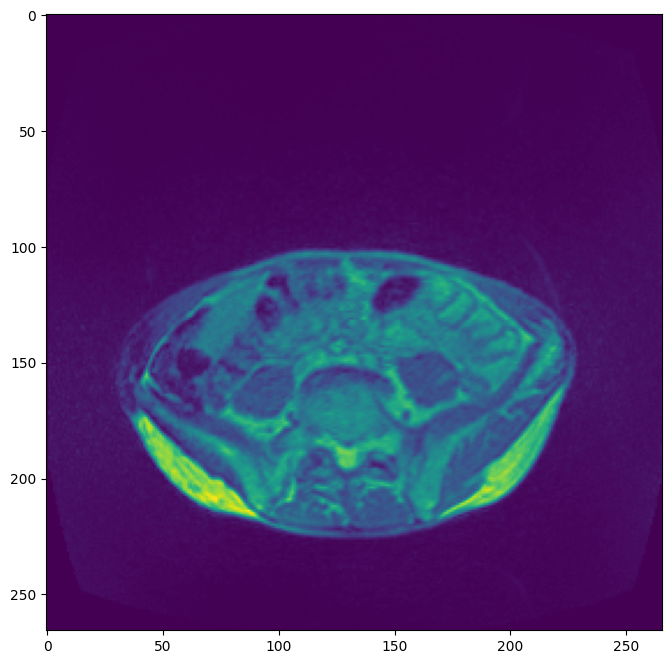

In [13]:
image = cv2.imread(train_images[143], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

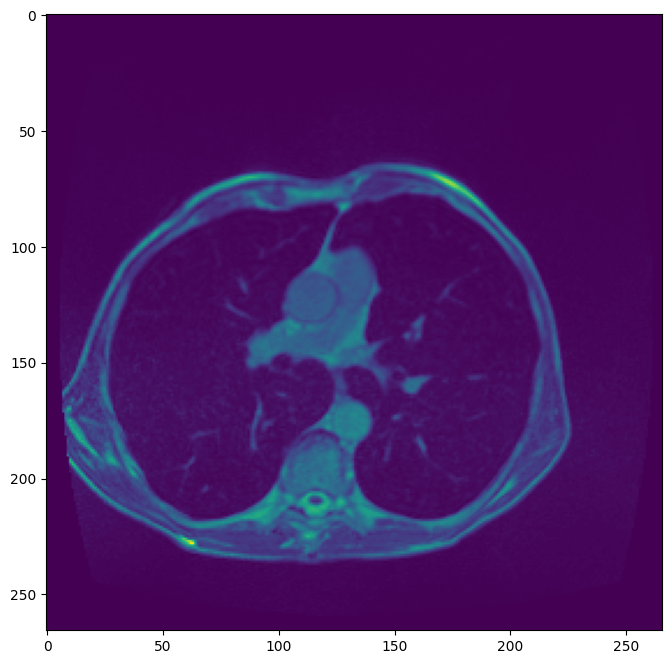

In [14]:
image = cv2.imread(train_images[1], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

## Run Length Encoding (RLE) images decoding

The segmentation (where doesn't have the value nan) is formed by a list of numbers containing different pixel points and their length. As an example:

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

where:

28094, 28358, 28623 etc. are the startpoints of the pixels within the matrix
and 3, 7, 9, 9 etc. are how long to strech the startpoints - meaning the total length
hence we can compute the endpoint of each of these segments as the sum of startpoints + endpoints

In [2]:
def rle2mask(mask_rle, shape):
    if not mask_rle or mask_rle == '':
        return np.zeros(shape, dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    for start, end in zip(starts, ends):
        img[start:end] = 1
    
    return img.reshape(shape)

Use `pathToInfo` to Extract Metadata for All Images

In [3]:
def pathToInfo(path):
    try:
        path_segments = path.split('/')
        if len(path_segments) < 8:
            raise ValueError("Path does not contain enough segments")
        
        caseDay = path_segments[5]
        slice_no = path_segments[7].split('_')[1]
        id = caseDay + '_slice_' + slice_no
        
        details = path_segments[7].split('_')
        if len(details) < 6:
            raise ValueError("Path details segment does not contain enough parts")
        
        height = details[2]
        width = details[3]
        h_spacing = details[4]
        w_spacing = details[5][:-4]  # Remove the file extension
        
        return pd.Series([id, height, width, h_spacing, w_spacing])
    
    except IndexError:
        print(f"IndexError processing path: {path}")
        return pd.Series([None, None, None, None, None])
    except ValueError as ve:
        print(f"ValueError: {ve} for path: {path}")
        return pd.Series([None, None, None, None, None])

In [15]:
# Create a DataFrame from the image paths
path_details_df = pd.DataFrame(train_images, columns=['path'])

# Apply the function to extract details and create columns for id, height, width, h_spacing, w_spacing
path_details_df[['id', 'height', 'width', 'h_spacing', 'w_spacing']] = path_details_df['path'].apply(func=lambda x: pathToInfo(x))

# Check the resulting DataFrame
path_details_df.head()

# Merge the new DataFrame with the existing one
new_df = df.merge(path_details_df, on='id')

# Save the new DataFrame to CSV
new_df.to_csv('./train_dataset.csv', index=False)

ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0032_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0084_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0092_266_266_1.50_1.50.png
ValueError: Path details segment does not contain enough parts for path: /Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scan

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



NameError: name 'df' is not defined

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [32]:
train_seg = train_data.dropna()

In [33]:
train_seg.head()

id    class  \
194  case123_day20_slice_0065  stomach   
197  case123_day20_slice_0066  stomach   
200  case123_day20_slice_0067  stomach   
203  case123_day20_slice_0068  stomach   
206  case123_day20_slice_0069  stomach   

                                          segmentation  
194  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...  
197  27561 8 27825 11 28090 13 28355 14 28620 15 28...  
200  15323 4 15587 8 15852 10 16117 11 16383 12 166...  
203  14792 5 15056 9 15321 11 15587 11 15852 13 161...  
206  14526 6 14789 12 15054 14 15319 16 15584 17 15...

In [34]:
train_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33913 entries, 194 to 115465
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [35]:
train_seg['segmentation'].iloc[0]

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

In [36]:
mask1 = rle2mask(train_seg['segmentation'].iloc[0], image.shape)

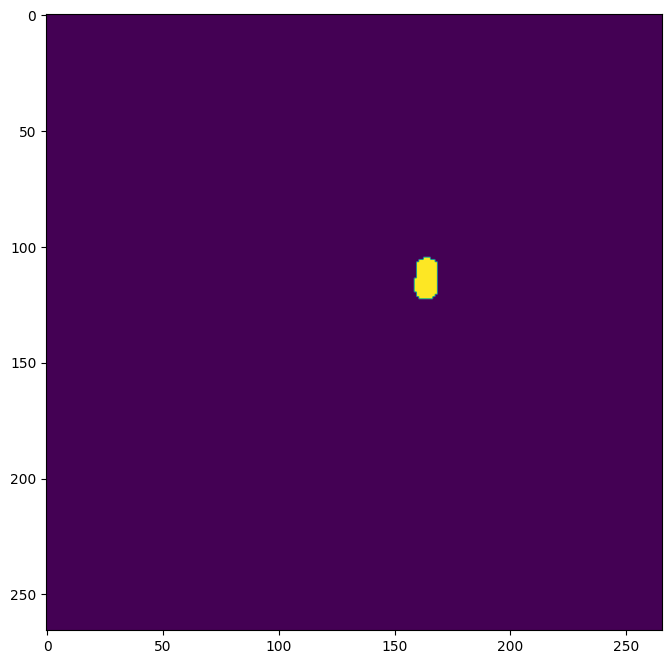

In [37]:
plt.imshow(mask1)

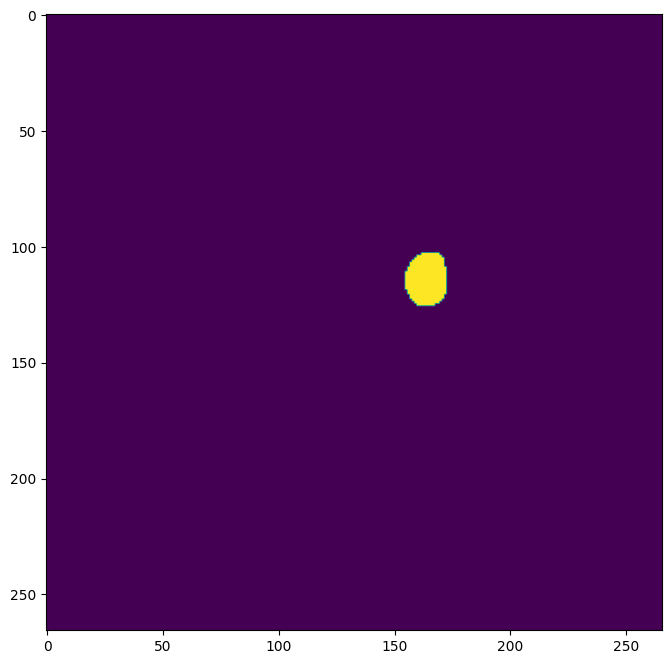

In [38]:
mask2 = rle2mask(train_seg['segmentation'].iloc[1], image.shape)
plt.imshow(mask2)

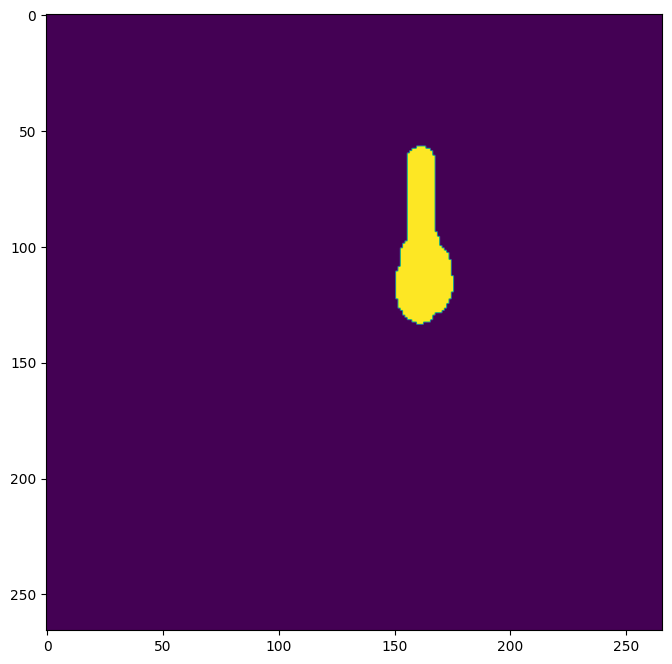

In [39]:
mask3 = rle2mask(train_seg['segmentation'].iloc[2], image.shape)
plt.imshow(mask3)

14792 5 15056 9 15321 11 15587 11 15852 13 16118 13 16383 15 16649 15 16915 15 17180 16 17446 16 17712 16 17978 16 18244 16 18510 16 18776 16 19042 16 19308 16 19574 16 19840 16 20106 16 20372 16 20638 16 20904 16 21170 16 21436 16 21702 16 21968 16 22234 16 22500 16 22766 16 23032 16 23298 17 23564 17 23830 17 24096 17 24362 17 24628 17 24894 17 25159 18 25425 18 25691 19 25956 20 26221 21 26487 22 26752 23 27017 25 27283 25 27549 25 27815 26 28081 26 28347 26 28613 27 28878 28 29144 28 29409 29 29674 30 29939 32 30201 36 30465 38 30729 40 30993 41 31258 42 31523 43 31788 44 32054 44 32320 44 32586 44 32852 43 33118 43 33385 41 33652 40 33920 7 33928 29 34195 28 34462 26 34729 23 34996 19 35268 12 35535 10 35803 7


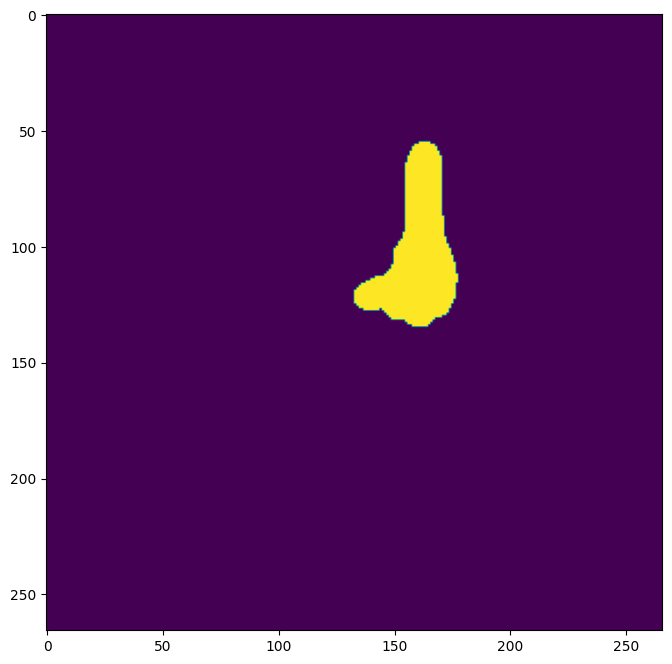

In [40]:
mask4 = rle2mask(train_seg['segmentation'].iloc[3], image.shape)
print(train_seg['segmentation'].iloc[3])
plt.imshow(mask4)

In [41]:
test=pd.read_csv('data.csv')

In [42]:
print(test[test['id'].str.contains('case123_day20_slice_0065')].stomach_rle.values)

['28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6']


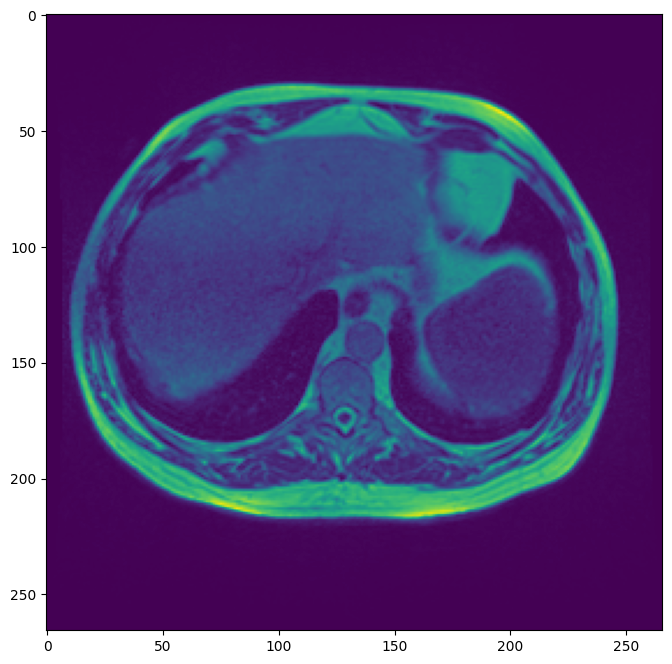

In [43]:
mage = cv2.imread(r'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png', cv2.IMREAD_UNCHANGED)
plt.imshow(mage)

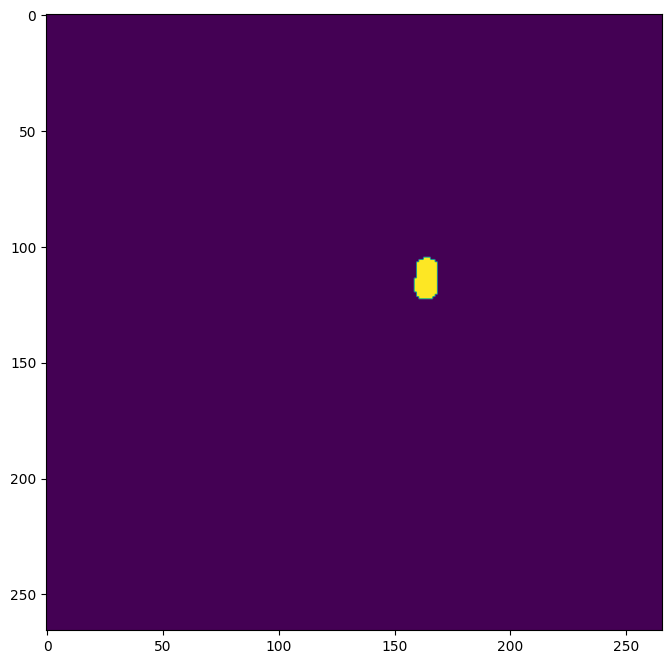

In [44]:
test_mask = rle2mask(test[test['id'].str.contains('case123_day20_slice_0065')].stomach_rle.values[0], image.shape)
plt.imshow(test_mask)

In [5]:
test=pd.read_csv('data.csv')
test_clean= test.dropna(subset=['stomach_rle','large_bowel_rle','small_bowel_rle'], thresh=1)

In [46]:
test_clean

id  \
64     case123_day20_slice_0065   
65     case123_day20_slice_0066   
66     case123_day20_slice_0067   
67     case123_day20_slice_0068   
68     case123_day20_slice_0069   
...                         ...   
38484    case30_day0_slice_0133   
38485    case30_day0_slice_0134   
38486    case30_day0_slice_0135   
38487    case30_day0_slice_0136   
38488    case30_day0_slice_0137   

                                             stomach_rle  \
64     28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...   
65     27561 8 27825 11 28090 13 28355 14 28620 15 28...   
66     15323 4 15587 8 15852 10 16117 11 16383 12 166...   
67     14792 5 15056 9 15321 11 15587 11 15852 13 161...   
68     14526 6 14789 12 15054 14 15319 16 15584 17 15...   
...                                                  ...   
38484                                                NaN   
38485                                                NaN   
38486                                                NaN   
38487                                                NaN   
38488                                                NaN   

                                         large_bowel_rle  \
64                                                   NaN   
65                                                   NaN   
66                                                   NaN   
67                                                   NaN   
68                                                   NaN   
...                                                  ...   
38484  17695 8 17957 23 18213 39 18477 45 18741 52 19...   
38485  17694 5 17957 10 18215 2 18219 17 18478 32 187...   
38486  17957 1 18219 10 18482 16 18744 23 19008 43 19...   
38487  18746 7 19009 23 19038 7 19273 44 19537 49 198...   
38488  18746 2 19010 8 19040 3 19274 25 19302 12 1953...   

                                         small_bowel_rle  
64                                                   NaN  
65                                                   NaN  
66                                                   NaN  
67                                                   NaN  
68                                                   NaN  
...                                                  ...  
38484  23337 15 23601 20 23866 23 24131 25 24396 27 2...  
38485  23336 13 23601 16 23867 18 24132 20 24398 21 2...  
38486  22540 1 22804 5 23069 7 23334 10 23600 11 2386...  
38487  23079 1 23343 6 23608 9 23874 11 24139 13 2440...  
38488  21457 6 21722 10 21987 15 22252 18 22517 21 22...  

[16590 rows x 4 columns]

In [6]:
import shutil, os



path = r'./stomach_data_and_masks'

for index, row in test_clean.iterrows():
    id_full = row.id
    id = id_full.split('_')
    files = os.listdir(rf'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/{id[0]}/{id[0]}_{id[1]}/scans')
    for file in os.listdir(rf'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/{id[0]}/{id[0]}_{id[1]}/scans'):
        split_file_name = file.split('_')
        if split_file_name[1]==id[3]:
            shutil.copyfile(rf'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/{id[0]}/{id[0]}_{id[1]}/scans/{file}', f'{path}/{id_full}.png')
            break
            
        
    
    #img_path = rf'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/{id[0]}/{id[0]}_{id[1]}/scans/slice_{id[3]}_266_266_1.50_1.50.png'
    #shutil.copyfile(rf'/Users/elizabethnemeti/Desktop/uw-madison-gi-tract-image-segmentation/train/{id[0]}/{id[0]}_{id[1]}/scans/slice_{id[3]}_266_266_1.50_1.50.png', f'{path}/{id_full}')
    #plt.imshow(image)
    #plt.savefig(f'{path}/{id_full}' )

In [ ]:
for index, row in test_clean.iterrows():
    id_full = row.id
    print(id_full)
    if type(row.stomach_rle)==str:
        test_mask = rle2mask(row.stomach_rle, image.shape)
        plt.imshow(test_mask)
        plt.axis('off')
        plt.savefig(f'./stomach_data_and_masks/{id_full}_stomach_mask.png', bbox_inches='tight', pad_inches=0)
        print('saved stomach')

    # if type(row.large_bowel_rle)==str:
    #     test_mask = rle2mask(row.large_bowel_rle, image.shape)
    #     plt.imshow(test_mask)
    #     plt.axis('off')
    #     plt.savefig(f'./all_masks/{id_full}_large_bowel_mask.png', bbox_inches='tight', pad_inches=0)
    #     print('saved large bowel')

    # if type(row.small_bowel_rle)==str:
    #     test_mask = rle2mask(row.small_bowel_rle, image.shape)
    #     plt.imshow(test_mask)
    #     plt.axis('off')
    #     plt.savefig(f'./all_masks/{id_full}_small_bowel_mask.png', bbox_inches='tight', pad_inches=0)
    #     print('saved small bowel')
    
        

   

case123_day20_slice_0065
saved stomach
case123_day20_slice_0066
saved stomach
case123_day20_slice_0067
saved stomach
case123_day20_slice_0068
saved stomach
case123_day20_slice_0069
saved stomach
case123_day20_slice_0070
saved stomach
case123_day20_slice_0071
saved stomach
case123_day20_slice_0072
saved stomach
case123_day20_slice_0073
saved stomach
case123_day20_slice_0074
saved stomach
case123_day20_slice_0075
saved stomach
case123_day20_slice_0076
saved stomach
case123_day20_slice_0077
saved stomach
case123_day20_slice_0078
saved stomach
case123_day20_slice_0079
saved stomach
case123_day20_slice_0080
saved stomach
case123_day20_slice_0081
saved stomach
case123_day20_slice_0082
saved stomach
case123_day20_slice_0083
saved stomach
case123_day20_slice_0084
saved stomach
case123_day20_slice_0085
saved stomach
case123_day20_slice_0086
saved stomach
case123_day20_slice_0087
saved stomach
case123_day20_slice_0088
saved stomach
case123_day20_slice_0089
saved stomach
case123_day20_slice_0090


KeyboardInterrupt: 

In [ ]:
for file in os.listdir(rf'./all_masks/'):
    if file.split('_')[-1] =='rle.png':
        new_name = file.split('rle')[0]
        new_name = f'{new_name}_mask.png'
        print(new_name)
        #os.rename(file, new_name)

## Moving towards making a little more sense of masks

In [49]:
train_seg['class'].value_counts()

class
large_bowel    14085
small_bowel    11201
stomach         8627
Name: count, dtype: int64

In [50]:
train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_46194/3778118854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)
/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_46194/3778118854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)
/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_46194/3778118854.py:1: Se

In [51]:
train_seg.drop('_', axis=1, inplace=True)

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_46194/3157862534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg.drop('_', axis=1, inplace=True)


In [52]:
train_seg.head()

id    class  \
194  case123_day20_slice_0065  stomach   
197  case123_day20_slice_0066  stomach   
200  case123_day20_slice_0067  stomach   
203  case123_day20_slice_0068  stomach   
206  case123_day20_slice_0069  stomach   

                                          segmentation     case    day slice  
194  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...  case123  day20  0065  
197  27561 8 27825 11 28090 13 28355 14 28620 15 28...  case123  day20  0066  
200  15323 4 15587 8 15852 10 16117 11 16383 12 166...  case123  day20  0067  
203  14792 5 15056 9 15321 11 15587 11 15852 13 161...  case123  day20  0068  
206  14526 6 14789 12 15054 14 15319 16 15584 17 15...  case123  day20  0069

In [53]:
train_seg['case'] = train_seg['case'].str.replace('case', '')

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_46194/2314378466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg['case'] = train_seg['case'].str.replace('case', '')


In [54]:
train_seg['day'] = train_seg['day'].str.replace('day', '')

/var/folders/fm/j8jgcsf90d1g6lkqzrw2mptw0000gn/T/ipykernel_46194/93224464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_seg['day'] = train_seg['day'].str.replace('day', '')


In [55]:
train_seg.head()

id    class  \
194  case123_day20_slice_0065  stomach   
197  case123_day20_slice_0066  stomach   
200  case123_day20_slice_0067  stomach   
203  case123_day20_slice_0068  stomach   
206  case123_day20_slice_0069  stomach   

                                          segmentation case day slice  
194  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...  123  20  0065  
197  27561 8 27825 11 28090 13 28355 14 28620 15 28...  123  20  0066  
200  15323 4 15587 8 15852 10 16117 11 16383 12 166...  123  20  0067  
203  14792 5 15056 9 15321 11 15587 11 15852 13 161...  123  20  0068  
206  14526 6 14789 12 15054 14 15319 16 15584 17 15...  123  20  0069

In [56]:
train_data['id'].value_counts()

id
case123_day20_slice_0001    3
case55_day18_slice_0091     3
case55_day18_slice_0093     3
case55_day18_slice_0094     3
case55_day18_slice_0095     3
                           ..
case49_day13_slice_0049     3
case49_day13_slice_0050     3
case49_day13_slice_0051     3
case49_day13_slice_0052     3
case30_day0_slice_0144      3
Name: count, Length: 38496, dtype: int64

In [57]:
enum = ['stomach', 'large_bowel', 'small_bowel']

In [58]:
unique_ids = train_data['id'].unique()

In [59]:
unique_ids

array(['case123_day20_slice_0001', 'case123_day20_slice_0002',
       'case123_day20_slice_0003', ..., 'case30_day0_slice_0142',
       'case30_day0_slice_0143', 'case30_day0_slice_0144'], dtype=object)

In [60]:
for id in unique_ids:
    idx = train_data[train_data.id == id]
    print(idx)
    break

                         id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN


In [61]:
df = pd.DataFrame()
df['id'] = unique_ids
df['stomach_rle'] = pd.Series(dtype='string')
df['large_bowel_rle'] = pd.Series(dtype='string')
df['small_bowel_rle'] = pd.Series(dtype='string')

In [62]:
df.head()

id stomach_rle large_bowel_rle small_bowel_rle
0  case123_day20_slice_0001        <NA>            <NA>            <NA>
1  case123_day20_slice_0002        <NA>            <NA>            <NA>
2  case123_day20_slice_0003        <NA>            <NA>            <NA>
3  case123_day20_slice_0004        <NA>            <NA>            <NA>
4  case123_day20_slice_0005        <NA>            <NA>            <NA>

TODO: Vectorize the following code for speed up

In [63]:
for i, id in enumerate(unique_ids):
    idx = train_data[train_data.id == id]
    for index, row in idx.iterrows():
        rle = row['segmentation']
        if row['class'] == 'stomach':
            df.at[i,'stomach_rle'] = rle
        elif row['class'] == 'large_bowel':
            df.at[i,'large_bowel_rle'] = rle
        elif row['class'] == 'small_bowel':
            df.at[i,'small_bowel_rle'] = rle

KeyboardInterrupt: 

In [ ]:
df

In [ ]:
df.info()

Above data indicates that most scans don't have masks

Saving the df to csv, as the above code is for readibility purposes and hence not the most efficient code. 

In [ ]:
df.to_csv('./data.csv', index=False)

In [ ]:
train_images[0]

We need to add all these paths to our dataset against their respective cases for easy access of images

In [ ]:
df.head()

Now we can add all these paths to our dataframe

In [ ]:
path_details_df.head()

Now we merge this path_details_df with our previous data df, to have a final dataset

In [ ]:
new_df = df.merge(path_details_df, on ='id')
new_df.head()

Save this dataframe to a csv to reduce computation time later.

In [ ]:
new_df.to_csv('./train_dataset.csv')
new_df.info()

Plotting scans and their masks

In [ ]:
new_df = new_df.fillna('')

In [ ]:
new_df.head()

In [ ]:
for idx, row in new_df[(new_df['stomach_rle'] != '')].iloc[20:21,:].iterrows():
    fig, axis = plt.subplots(1,4)
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[0].imshow(image, cmap='gray')
    axis[1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    print(row)

In [ ]:
rcParams['figure.figsize'] = 20, 20
fig, axis = plt.subplots(5,4)
i = 0
for idx, row in new_df[new_df['stomach_rle'] != ''].iloc[18:23,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    axis[i,1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    i += 1

In [ ]:
rcParams['figure.figsize'] = 20, 20
fig, axis = plt.subplots(5,4)
i = 0
for idx, row in new_df[new_df['stomach_rle'] != ''].iloc[10:15,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    axis[i,1].imshow(rle2mask(row['stomach_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,2].imshow(rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    axis[i,3].imshow(rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height']))), cmap='gray')
    i += 1

In [ ]:
rcParams['figure.figsize'] = 10,20
fig, axis = plt.subplots(5,2)
i = 0
for idx, row in new_df[(new_df['stomach_rle'] != '')].iloc[18:23,:].iterrows():
    image = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
    axis[i,0].imshow(image, cmap='gray')
    s_mask = rle2mask(row['stomach_rle'], (int(row['width']), int(row['height'])))
    lb_mask = rle2mask(row['large_bowel_rle'], (int(row['width']), int(row['height'])))
    sb_mask = rle2mask(row['small_bowel_rle'], (int(row['width']), int(row['height'])))
    
    mask = s_mask + lb_mask + sb_mask
    
    axis[i,1].imshow(mask, cmap='gray')
    i += 1